In [21]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

Initiate directories:

In [12]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'
cities = pd.read_csv(ROOT_DIR + config['cities'])

Cities information, eg. to loop over city names:

In [13]:
cities[:7]

,city,latitude,longitude
0,ALE,82.492,-62.508
1,ABZ,12.990,50.570
2,ASP,58.800,17.380
3,BOT,-25.500,25.800
4,BSL,53.000,7.950
5,EGB,44.200,-79.800
6,HEL,60.200,24.960


In [18]:
city = cities['city'][6]

Open data file:

In [19]:
df = pd.read_csv(DATA_DIR + city + '.csv', index_col='date')

In [20]:
df.head()

,concentration,t,co
date,,,
2005-01-01,745.769167,271.50780,1.924972e-07
2005-01-02,374.991806,272.57120,1.903695e-07
2005-01-03,265.290294,272.60297,1.779340e-07
2005-01-04,304.682014,270.91785,2.032431e-07
2005-01-05,409.387986,272.37310,2.047700e-07


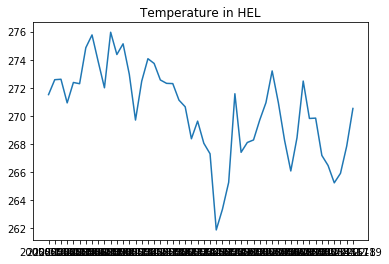

In [26]:
plt.plot(df.index[:50], df['t'][:50])
plt.title('Temperature in ' + city)
plt.show()